# Evaulate uncertainty measure
- To evaluate different uncertainty measure, use AUROC. 
- Uncertainty measure expected to be higher for incorrect answers and lower for correct answers. As we want to show the relationship incorrect answer -> High uncertainty, incorrect answers are encoded with label 1, correct answers with label 0 
- Compute AUROC score for each uncertainty measure with sklearn.metrics.roc_auc_score([0, 0, 0, 1, 1, 0, ...], [semantic entropy scores of the answers])



In [83]:
import numpy as np
import yaml
import glob
import pickle
import pandas as pd
import os
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
def load_pickle_files(folder):
    data_groups = []
    pickle_files = glob.glob(f"{folder}/group*.pkl")
    for pickle_file in pickle_files:
        with open(pickle_file, "rb") as f:
            data_groups.append(pickle.load(f))

    return data_groups

In [3]:
save_path = config["path_to_saved_generations"]
data_groups = load_pickle_files(save_path)
keys_data = [f"temperature_{temp}" for temp in config["temperatures"]] + [f"beam_{beam}" for beam in config["n_beams"]]

## Save results

In [4]:
general_columns = ["question_id", "group"]
correct_columns = ["rougel_0.3", "rougel_0.5", "rouge1_0.5", "entailment", "label_by_hand"]
predictive_entropy_columns = [f"pred_entropy_temperature_{s}" for s in config["temperatures"]] + [
    f"pred_entropy_beam_{s}" for s in config["n_beams"]]
length_normalized_entropy_columns = [f"length_normalized_pred_entropy_temperature_{s}" for s in
                                     config["temperatures"]] + [
                                        f"length_normalized_pred_entropy_beam_{s}" for s in config["n_beams"]]
n_semantically_distinct_columns = [f"n_semantically_distinct_temperature_{s}" for s in config["temperatures"]] + [
    f"n_semantically_distinct_beam_{s}" for s in config["n_beams"]]
semantic_entropy_columns = [f"sem_entropy_temperature_{s}" for s in config["temperatures"]] + [
    f"sem_entropy_beam_{s}" for s in config["n_beams"]]

results = pd.DataFrame(
    columns=general_columns + correct_columns + predictive_entropy_columns + length_normalized_entropy_columns + n_semantically_distinct_columns + semantic_entropy_columns)

In [5]:
data_groups = load_pickle_files(save_path)

for group_nr, group_info in enumerate(data_groups):
    for question_idx in group_info.keys():
        new_row = {"question_id": question_idx, "group": group_nr}
        results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

In [8]:
# Store it for now
results.to_csv(os.path.join(save_path, "results.csv"), index=False)

In [14]:
# Fill in correct_columns
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers = pickle.load(f)

for question_idx, info in greedy_answers.items():
    results.loc[results["question_id"] == question_idx, "rougel_0.3"] = info["rouge_l_score"] > 0.3
    results.loc[results["question_id"] == question_idx, "rougel_0.5"] = info["rouge_l_score"] > 0.5
    results.loc[results["question_id"] == question_idx, "rouge1_0.5"] = info["rouge_1_score"] > 0.5
    results.loc[results["question_id"] == question_idx, "entailment"] = info["result_entail"]
    results.loc[results["question_id"] == question_idx, "label_by_hand"] = info["label_by_hand"]

In [15]:
# Store it for now
results.to_csv(os.path.join(save_path, "results.csv"), index=False)

## Predictive Entropy

The predictive entropy is defined as:
$$PE(x) = H[p(s \mid x)] = - \sum_{s} p(s \mid x) \ln p(s \mid x)$$

Since this is the expected value of $\ln p(s \mid x)$, Monte Carlo sampling approximates it by averaging log-probabilities from sampled outcomes. Thus, the Monte Carlo estimator is:
$$PE(x) \approx - \frac{1}{n}  \sum_{i = 1}^{n} \ln p(s_i \mid x)$$ where $n$ is the number of sampled answers for the question $x$.

In [27]:
def predictive_entropy(probabilities):
    return -1 / len(probabilities) * np.sum(np.log(probabilities))

In [28]:
data_groups = load_pickle_files(save_path)
for group_nr, group_info in enumerate(data_groups):
    for question_idx in group_info.keys():
        for key in keys_data:
            key_string = f"pred_entropy_{key}"
            probabilities = group_info[question_idx][key]["probabilities"]
            results.loc[
                (results["question_id"] == question_idx) & (
                        results["group"] == group_nr), key_string] = predictive_entropy(
                probabilities)

In [32]:
results.to_csv(os.path.join(save_path, "results.csv"), index=False)

## Length-normalized predictive entropy
Paper (page 8): "Length-normalised predictive entropy divides the joint log-probability of each sequence by the length of the sequence"

In [53]:
def length_normalized_predictive_entropy(probabilities, sequence_length):
    return -1 / len(probabilities) * np.sum(np.log(probabilities) / sequence_length)

In [54]:
data_groups = load_pickle_files(save_path)
for group_nr, group_info in enumerate(data_groups):
    for question_idx in group_info.keys():
        for key in keys_data:
            key_string = f"length_normalized_pred_entropy_{key}"
            probabilities = group_info[question_idx][key]["probabilities"]
            length_sequences = group_info[question_idx][key]["length_sequences"]
            results.loc[
                (results["question_id"] == question_idx) & (
                        results["group"] == group_nr), key_string] = length_normalized_predictive_entropy(
                probabilities, length_sequences)

In [56]:
results.to_csv(os.path.join(save_path, "results.csv"), index=False)

## Number of semantically distinct answers

In [58]:
data_groups = load_pickle_files(save_path)
for group_nr, group_info in enumerate(data_groups):
    for question_idx in group_info.keys():
        for key in keys_data:
            key_string = f"n_semantically_distinct_{key}"
            sem_eq_groups = group_info[question_idx][key]["semantic_eq_groups"]
            results.loc[
                (results["question_id"] == question_idx) & (
                        results["group"] == group_nr), key_string] = len(set(sem_eq_groups))

In [60]:
results.to_csv(os.path.join(save_path, "results.csv"), index=False)

## Semantic Entropy

The semantic entropy is defined as (see equation 3):
$$SE(x) = - \sum_{c} p(c \mid x) \ln p(c \mid x) = -\sum_{c} \left( \left( \sum_{s \in c} p(s \mid x) \right) \log \left( \sum_{s \in c} p(s \mid x) \right) \right)$$

where c stand for the semantic equivalence classes. By sampling from the possible semantic equivalence classes, the Monte Carlo estimator is given by:
$$SE(x) \approx - \frac{1}{n}  \sum_{i = 1}^{n} \ln p(c_i \mid x)$$ where $n$ is the number of sampled semantic equivalence classes for the question $x$.

In [63]:
def semantic_entropy(probabilities, lexical_eq_classes, semantic_eq_classes):
    prob_sem_class = np.zeros(len(set(semantic_eq_classes)))
    lexical_contained = {sem_class: set() for sem_class in set(semantic_eq_classes)}

    for i in range(len(probabilities)):
        sem_class = semantic_eq_classes[i]
        lex_class = lexical_eq_classes[i]
        if lex_class not in lexical_contained[sem_class]:
            prob_sem_class[sem_class] += probabilities[i]
            lexical_contained[sem_class].add(lex_class)

    return -1 / len(prob_sem_class) * np.sum(np.log(prob_sem_class))

In [65]:
data_groups = load_pickle_files(save_path)
for group_nr, group_info in enumerate(data_groups):
    for question_idx in group_info.keys():
        for key in keys_data:
            key_string = f"sem_entropy_{key}"
            probabilities = group_info[question_idx][key]["probabilities"]
            lexical_eq_classes = group_info[question_idx][key]["lexical_eq_groups"]
            sem_eq_classes = group_info[question_idx][key]["semantic_eq_groups"]
            results.loc[
                (results["question_id"] == question_idx) & (
                        results["group"] == group_nr), key_string] = semantic_entropy(probabilities, lexical_eq_classes,
                                                                                      sem_eq_classes)

In [67]:
results.to_csv(os.path.join(save_path, "results.csv"), index=False)

## Compute AUROC
### Compare AUROC value for different temperature scores and uncertainty measures
Paper: Figure 3 (b); Use label_by_hand to label answers as correct/false.

In [68]:
auroc_pred_entropy = {k: [] for k in keys_data}
auroc_length_normalized_entropy = {k: [] for k in keys_data}
auroc_n_semantically_distrinct = {k: [] for k in keys_data}
auroc_semantically_entropy = {k: [] for k in keys_data}

In [72]:
for group_nr in range(len(data_groups)):
    label_correct = results.loc[results["group"] == group_nr, "label_by_hand"].astype(bool)
    for k in keys_data:
        pred_entropy = results.loc[results["group"] == group_nr, f"pred_entropy_{k}"]
        length_normalized_pred_entropy = results.loc[
            results["group"] == group_nr, f"length_normalized_pred_entropy_{k}"]
        n_semantically_distinct = results.loc[results["group"] == group_nr, f"n_semantically_distinct_{k}"]
        sem_entropy = results.loc[results["group"] == group_nr, f"sem_entropy_{k}"]

        auroc_pred_entropy[k].append(roc_auc_score(~label_correct, pred_entropy))
        auroc_length_normalized_entropy[k].append(roc_auc_score(~label_correct, length_normalized_pred_entropy))
        auroc_n_semantically_distrinct[k].append(roc_auc_score(~label_correct, n_semantically_distinct))
        auroc_semantically_entropy[k].append(roc_auc_score(~label_correct, sem_entropy))

In [79]:
# Preprocessing
def convert_to_df(dictionary_auroc):
    temp = pd.DataFrame(dictionary_auroc, index=pd.Index([f"group_{i}" for i in range(len(data_groups))], name="group"))
    temp.reset_index(inplace=True)
    return temp


auroc_pred_entropy = convert_to_df(auroc_pred_entropy)
auroc_length_normalized_entropy = convert_to_df(auroc_length_normalized_entropy)
auroc_n_semantically_distrinct = convert_to_df(auroc_n_semantically_distrinct)
auroc_semantically_entropy = convert_to_df(auroc_semantically_entropy)

In [81]:
# Plot temperature
def preprocess_df_temperature(df):
    df_new = df.drop(columns=df.filter(like="beam_").columns)
    df_new = pd.melt(df_new, id_vars=["group"], value_name="auroc", var_name="temperature")
    df_new["group"] = df_new["group"].str.replace("group_", "").astype(int)
    df_new["temperature"] = df_new["temperature"].str.replace("temperature_", "").astype(float)
    return df_new


auroc_pred_entropy_temp = preprocess_df_temperature(auroc_pred_entropy)
auroc_length_normalized_entropy_temp = preprocess_df_temperature(auroc_length_normalized_entropy)
auroc_n_semantically_distrinct_temp = preprocess_df_temperature(auroc_n_semantically_distrinct)
auroc_semantically_entropy_temp = preprocess_df_temperature(auroc_semantically_entropy)

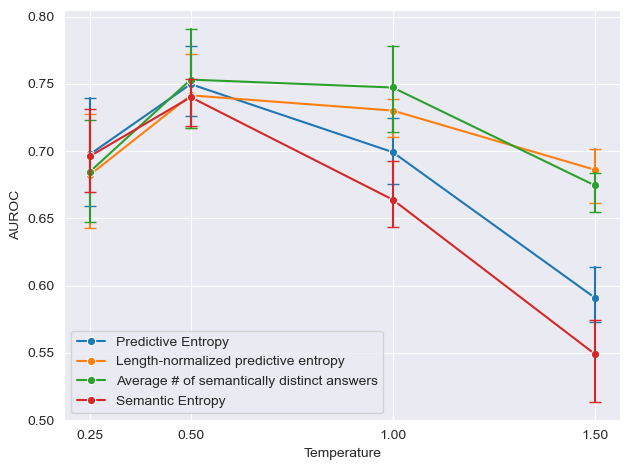

In [84]:
plt.figure()
sns.lineplot(data=auroc_pred_entropy_temp, x="temperature", y="auroc", errorbar="pi", estimator="mean", marker="o",
             err_style="bars", err_kws={"capsize": 4}, linewidth=1.5, label="Predictive Entropy")
sns.lineplot(data=auroc_length_normalized_entropy_temp, x="temperature", y="auroc", errorbar="pi", estimator="mean",
             marker="o", err_style="bars", err_kws={"capsize": 4}, linewidth=1.5,
             label="Length-normalized predictive entropy")
sns.lineplot(data=auroc_n_semantically_distrinct_temp, x="temperature", y="auroc", errorbar="pi", estimator="mean",
             marker="o", err_style="bars", err_kws={"capsize": 4}, linewidth=1.5,
             label="Average # of semantically distinct answers")
sns.lineplot(data=auroc_semantically_entropy_temp, x="temperature", y="auroc", errorbar="pi", estimator="mean",
             marker="o", err_style="bars", err_kws={"capsize": 4}, linewidth=1.5, label="Semantic Entropy")

plt.xlabel("Temperature")
plt.ylabel("AUROC")
plt.xticks(config["temperatures"])
plt.tight_layout()
plt.show()

Same observation as in the paper: AUROC values highest for temperature 0.5

For temperature 0.5 Average number of semantically distinct answers highest, but semantic entropy very close by.

Paper shows result starting from the model with 2.7B parameters. There semantic entropy, predictive entropy and normalized entropy also almost equal (see Figure 2 b))

### Compare AUROC value for best temperature (TODO) and beam

### Compare different accuracy metrics for the free-form QA
Paper: page 17

Used best temperature/beam

In [ ]:
auroc_pred_entropy = {k: [] for k in keys_data}
auroc_length_normalized_entropy = {k: [] for k in keys_data}
auroc_n_semantically_distrinct = {k: [] for k in keys_data}
auroc_

## Plots
- Bar plot: x-axis Semantic entropy, normalised entropy, entropy; y-axis: AUROC (page 2)
- Table 2
- x-axis Temperature, y-axis AUROC (2 lines: semantic entropy, length-normalised entropy)


TODO: Compare multiple number of samples used to estimate entropy
- x-axis number samples used to estimate entropy, y-axis AUROC; lines: Semantic entropy, length-normalised entropy, entropy

In [ ]:
# TODO